<a href="https://colab.research.google.com/github/sylvas-j/ML/blob/master/Tensorflow_works/SmartHome_ModelProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from keras.models import Sequential, load_model
from keras.layers import Dense
# from keras.layers import LSTM
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

# multi-class classification with Keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import(
    classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error
)
from sklearn.preprocessing import (
    StandardScaler, LabelBinarizer, FunctionTransformer,PolynomialFeatures, OrdinalEncoder,LabelEncoder,MinMaxScaler
)
# from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import VarianceThreshold
from keras.utils import np_utils

In [3]:
# import mitosheet

####Basic Functions

In [4]:
class ResultSummary:
  # matrix = classification_report(actual,predicted,labels=[1,0])
  def classification_reportx(y_test,y_predicted):
    matrix = classification_report(y_test,y_predicted, labels=pd.unique(y_predicted))
    # matrix = classification_report(reverse_encoded_y_test,reverse_encoded_y_predicted, labels=pd.unique(reverse_encoded_y_predicted))
    print(matrix)
  # classification_reportx(reverse_encoded_y_test,reverse_encoded_y_predicted)


  # confusion_matrix(reverse_encoded_y_test, reverse_encoded_y_predicted)
  # pd.crosstab(reverse_encoded_y_test, reverse_encoded_y_predicted, rownames=['True'], colnames=['Predicted'], margins=True)
  def confusion_matrixx(y_test, y_pred,figsize1,figsize2):
    %matplotlib inline
    # fig, ax = plt.subplots(figsize=(12,10))
    fig, ax = plt.subplots(figsize=(figsize1,figsize2))
    # cm = confusion_matrix(reverse_encoded_y_test, reverse_encoded_y_predicted)
    cm = confusion_matrix(y_test, y_pred)
    # df_cm = pd.DataFrame(cm, index=pd.unique(reverse_encoded_y_test), columns=pd.unique(reverse_encoded_y_test))
    df_cm = pd.DataFrame(cm, index=pd.unique(y_test), columns=pd.unique(y_test))
    ax = sns.heatmap(df_cm,  cbar = False, cmap="BuGn", annot=True, fmt="d", linewidths=.5, ax=ax)
    # plt.setp(ax.get_xticklabels(), rotation=45)
    plt.ylabel('True label', fontweight='bold', fontsize = 18)
    plt.xlabel('Predicted label', fontweight='bold', fontsize = 18) 
    plt.show()
  # confusion_matrixx(reverse_encoded_y_test, reverse_encoded_y_predicted,12,10)
  


  def actual_n_predictions(reverse_encoded_y_test,reverse_encoded_y_predicted):
    for i in range(len(reverse_encoded_y_test)):
      print("Test: %s -------- Predicted: (%s)" % (reverse_encoded_y_test[i], reverse_encoded_y_predicted[i]))



# class for Y convertions
class TextLabelEncoderDummy:

  def labelencoder(y_df):
    encoder = LabelEncoder()
    encoder.fit(y_df)
    encoded_Y = encoder.transform(y_df)
    return encoded_Y, encoder


  def encoded_to_dummy(encoded_Y):
    # convert encoder variable to dummy variable
    uniques, ids = np.unique(encoded_Y, return_inverse=True)
    dummy_y = np_utils.to_categorical(ids, len(uniques))
    # dummy_y = np_utils.to_categorical(encoded_Y)
    return dummy_y, uniques


  def reverse_dummy_to_encoded(y_test):
    reverse_dummy = uniques[y_test.argmax(1)]
    return reverse_dummy


  def reverse_encoded_to_text(reverse_dummy):
    reverse_encoded = encoder.inverse_transform(reverse_dummy)
    return reverse_encoded

#### For Google Colab

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Ms Imumisen/smart_home_ds.csv")

#### For Jupyter Lap

In [ ]:
data= pd.read_csv('D:\\Desktop Files\\weka data\\Ms Imumu\\hh130\\hh130.ann.features.csv')

In [ ]:
mitosheet.sheet(data)

MitoWidget(analysis_name='UUID-716c6500-92c2-499a-8c65-195f4a60998b', code_json='{"imports": "from mitosheet i…

In [ ]:
# MITO CODE START (DO NOT EDIT)

from mitosheet import * # Import necessary functions from Mito
register_analysis('UUID-716c6500-92c2-499a-8c65-195f4a60998b') # Let Mito know which analysis is being run

# Pivoted data into df2
df2 = pd.DataFrame(data={})

  
# MITO CODE END (DO NOT EDIT)

#### Data Wrangling and Processing

https://machinelearningmastery.com/data-preparation-techniques-for-machine-learning/

##### Data Cleaning: Identifying and correcting mistakes or errors in the data.
##### Feature Selection: Identifying those input variables that are most relevant to the task.
##### Data Transforms: Changing the scale or distribution of variables.
##### Feature Engineering: Deriving new variables from available data.
##### Dimensionality Reduction: Creating compact projections of the data.

In [7]:
data.head(4)

,lastSensorEventHours,lastSensorEventSeconds,lastSensorDayOfWeek,windowDuration,timeSinceLastSensorEvent,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,complexity,activityChange,areaTransitions,numDistinctSensors,sensorCount-Bathroom,sensorCount-Bedroom,sensorCount-Chair,sensorCount-DiningRoom,sensorCount-Hall,sensorCount-Ignore,sensorCount-Kitchen,sensorCount-LivingRoom,sensorCount-Office,sensorCount-OutsideDoor,sensorCount-WorkArea,sensorElTime-Bathroom,sensorElTime-Bedroom,sensorElTime-Chair,sensorElTime-DiningRoom,sensorElTime-Hall,sensorElTime-Ignore,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-Office,sensorElTime-OutsideDoor,sensorElTime-WorkArea,activity
0,2.0,7371.0,3.0,5722.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.498951,0.0,0.0,0.0,34.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86400.0,0.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep
1,2.0,7373.0,3.0,5723.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.710117,0.0,0.0,0.0,34.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86400.0,0.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep
2,2.0,7374.0,3.0,5496.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.698508,0.0,0.0,0.0,34.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86400.0,0.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep
3,2.0,7375.0,3.0,5496.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.698326,0.0,0.0,0.0,34.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86400.0,0.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep


In [8]:
# Shuffled dataset and divide into dependent and independent set
data_shuffled = data.sample(frac=1)

X_df = data_shuffled.drop(labels=['activity'], axis=1)
y_df = data_shuffled['activity']

In [9]:
y_df

154963               Phone
65371     Entertain_Guests
10579       Other_Activity
154398            Watch_TV
91458     Entertain_Guests
                ...       
44888               Toilet
77503     Entertain_Guests
150384              Toilet
53797               Toilet
74393       Other_Activity
Name: activity, Length: 157372, dtype: object

In [10]:
data.corr()

,lastSensorEventHours,lastSensorEventSeconds,lastSensorDayOfWeek,windowDuration,timeSinceLastSensorEvent,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,complexity,activityChange,areaTransitions,numDistinctSensors,sensorCount-Bathroom,sensorCount-Bedroom,sensorCount-Chair,sensorCount-DiningRoom,sensorCount-Hall,sensorCount-Ignore,sensorCount-Kitchen,sensorCount-LivingRoom,sensorCount-Office,sensorCount-OutsideDoor,sensorCount-WorkArea,sensorElTime-Bathroom,sensorElTime-Bedroom,sensorElTime-Chair,sensorElTime-DiningRoom,sensorElTime-Hall,sensorElTime-Ignore,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-Office,sensorElTime-OutsideDoor,sensorElTime-WorkArea
lastSensorEventHours,1.000000,0.998581,0.004958,-0.095645,-0.034804,0.200807,0.211911,0.133822,0.133822,0.148368,-0.034145,-0.005037,-0.021128,NaN,-0.112535,-0.134686,NaN,NaN,NaN,-0.047892,0.060029,0.244983,NaN,-0.010620,NaN,0.013302,0.161494,NaN,NaN,NaN,-0.148280,-0.286113,-0.266812,NaN,-0.118630,NaN
lastSensorEventSeconds,0.998581,1.000000,0.008052,-0.095057,-0.034541,0.200550,0.212061,0.132898,0.132898,0.147273,-0.035576,-0.005036,-0.022218,NaN,-0.110391,-0.135517,NaN,NaN,NaN,-0.047981,0.057927,0.245140,NaN,-0.011126,NaN,0.013728,0.161934,NaN,NaN,NaN,-0.148465,-0.285706,-0.266068,NaN,-0.118501,NaN
lastSensorDayOfWeek,0.004958,0.008052,1.000000,0.000474,0.001162,0.006574,0.005843,0.001191,0.001191,0.007354,-0.019884,-0.001008,-0.000396,NaN,0.011507,-0.009989,NaN,NaN,NaN,-0.029220,-0.005670,0.025060,NaN,-0.013449,NaN,-0.004421,-0.005140,NaN,NaN,NaN,0.000172,0.014175,0.043468,NaN,-0.015185,NaN
windowDuration,-0.095645,-0.095057,0.000474,1.000000,0.314408,-0.029632,-0.064792,0.021350,0.021350,0.036138,-0.313383,0.002748,-0.267356,NaN,-0.194275,0.135004,NaN,NaN,NaN,0.220572,-0.113131,-0.033380,NaN,0.001944,NaN,0.465764,0.354940,NaN,NaN,NaN,0.244148,0.192892,0.267309,NaN,0.471406,NaN
timeSinceLastSensorEvent,-0.034804,-0.034541,0.001162,0.314408,1.000000,-0.017921,-0.024935,0.015274,0.015274,0.031614,-0.101922,-0.142090,-0.079354,NaN,-0.067537,0.066774,NaN,NaN,NaN,0.043174,-0.038333,-0.014349,NaN,0.008017,NaN,0.131032,0.136262,NaN,NaN,NaN,0.099280,0.056365,0.083470,NaN,0.143315,NaN
prevDominantSensor1,0.200807,0.200550,0.006574,-0.029632,-0.017921,1.000000,0.477181,0.213728,0.213728,0.243117,0.075762,0.023516,0.021851,NaN,-0.272519,-0.240109,NaN,NaN,NaN,0.069521,0.182175,0.358118,NaN,0.014852,NaN,0.131014,0.191512,NaN,NaN,NaN,-0.076687,-0.222831,-0.174772,NaN,-0.032458,NaN
prevDominantSensor2,0.211911,0.212061,0.005843,-0.064792,-0.024935,0.477181,1.000000,0.152658,0.152658,0.170010,0.059542,0.012621,-0.003392,NaN,-0.132939,-0.197280,NaN,NaN,NaN,0.047996,0.131385,0.221019,NaN,0.020648,NaN,0.101285,0.151134,NaN,NaN,NaN,-0.077511,-0.225039,-0.179830,NaN,-0.044066,NaN
lastSensorID,0.133822,0.132898,0.001191,0.021350,0.015274,0.213728,0.152658,1.000000,1.000000,0.858334,0.112540,-0.036664,0.011326,NaN,-0.394281,-0.282614,NaN,NaN,NaN,0.146376,0.196547,0.424363,NaN,0.117750,NaN,0.078590,0.241835,NaN,NaN,NaN,-0.091702,-0.171262,-0.159933,NaN,-0.073881,NaN
lastSensorLocation,0.133822,0.132898,0.001191,0.021350,0.015274,0.213728,0.152658,1.000000,1.000000,0.858334,0.112540,-0.036664,0.011326,NaN,-0.394281,-0.282614,NaN,NaN,NaN,0.146376,0.196547,0.424363,NaN,0.117750,NaN,0.078590,0.241835,NaN,NaN,NaN,-0.091702,-0.171262,-0.159933,NaN,-0.073881,NaN
lastMotionLocation,0.148368,0.147273,0.007354,0.036138,0.031614,0.243117,0.170010,0.858334,0.858334,1.000000,0.122533,-0.070205,0.027712,NaN,-0.473448,-0.258489,NaN,NaN,NaN,0.110256,0.215386,0.466225,NaN,0.174744,NaN,0.102679,0.253689,NaN,NaN,NaN,-0.071910,-0.196571,-0.180780,NaN,-0.072909,NaN


In [11]:
data.corr().info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, lastSensorEventHours to sensorElTime-WorkArea
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lastSensorEventHours      25 non-null     float64
 1   lastSensorEventSeconds    25 non-null     float64
 2   lastSensorDayOfWeek       25 non-null     float64
 3   windowDuration            25 non-null     float64
 4   timeSinceLastSensorEvent  25 non-null     float64
 5   prevDominantSensor1       25 non-null     float64
 6   prevDominantSensor2       25 non-null     float64
 7   lastSensorID              25 non-null     float64
 8   lastSensorLocation        25 non-null     float64
 9   lastMotionLocation        25 non-null     float64
 10  complexity                25 non-null     float64
 11  activityChange            25 non-null     float64
 12  areaTransitions           25 non-null     float64
 13  numDistinctSensors        0 non-nu

In [12]:
corr_data = data.corr()

In [13]:
data.columns

Index(['lastSensorEventHours', 'lastSensorEventSeconds', 'lastSensorDayOfWeek',
       'windowDuration', 'timeSinceLastSensorEvent', 'prevDominantSensor1',
       'prevDominantSensor2', 'lastSensorID', 'lastSensorLocation',
       'lastMotionLocation', 'complexity', 'activityChange', 'areaTransitions',
       'numDistinctSensors', 'sensorCount-Bathroom', 'sensorCount-Bedroom',
       'sensorCount-Chair', 'sensorCount-DiningRoom', 'sensorCount-Hall',
       'sensorCount-Ignore', 'sensorCount-Kitchen', 'sensorCount-LivingRoom',
       'sensorCount-Office', 'sensorCount-OutsideDoor', 'sensorCount-WorkArea',
       'sensorElTime-Bathroom', 'sensorElTime-Bedroom', 'sensorElTime-Chair',
       'sensorElTime-DiningRoom', 'sensorElTime-Hall', 'sensorElTime-Ignore',
       'sensorElTime-Kitchen', 'sensorElTime-LivingRoom',
       'sensorElTime-Office', 'sensorElTime-OutsideDoor',
       'sensorElTime-WorkArea', 'activity'],
      dtype='object')

#### Filtering Columns with Contant Values

In [14]:
# Execute the following script to create a filter for constant features.
constant_filter = VarianceThreshold(threshold=0)
# Next, we need to simply apply this filter to our training set as shown in the following example:
constant_filter.fit(X_df)

VarianceThreshold(threshold=0)

In [15]:
# Execute the following script to see the number of non-constant features.

len(X_df.columns[constant_filter.get_support()])

25

In [16]:
# List of contants column
constant_columns = [column for column in X_df.columns
                    if column not in X_df.columns[constant_filter.get_support()]]

In [17]:
constant_columns

['numDistinctSensors',
 'sensorCount-Chair',
 'sensorCount-DiningRoom',
 'sensorCount-Hall',
 'sensorCount-Office',
 'sensorCount-WorkArea',
 'sensorElTime-Chair',
 'sensorElTime-DiningRoom',
 'sensorElTime-Hall',
 'sensorElTime-Office',
 'sensorElTime-WorkArea']

In [18]:
X_df.head(2)

,lastSensorEventHours,lastSensorEventSeconds,lastSensorDayOfWeek,windowDuration,timeSinceLastSensorEvent,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,complexity,activityChange,areaTransitions,numDistinctSensors,sensorCount-Bathroom,sensorCount-Bedroom,sensorCount-Chair,sensorCount-DiningRoom,sensorCount-Hall,sensorCount-Ignore,sensorCount-Kitchen,sensorCount-LivingRoom,sensorCount-Office,sensorCount-OutsideDoor,sensorCount-WorkArea,sensorElTime-Bathroom,sensorElTime-Bedroom,sensorElTime-Chair,sensorElTime-DiningRoom,sensorElTime-Hall,sensorElTime-Ignore,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-Office,sensorElTime-OutsideDoor,sensorElTime-WorkArea
154963,12.0,44900.0,4.0,336.0,15.0,1.0,0.0,7.0,7.0,7.0,0.468996,0.205357,0.0,0.0,0.0,0.00,0.0,0.0,0.0,3.74,0.0,30.61,0.0,0.00,0.0,487.573256,336.189375,86400.0,86400.0,86400.0,303.799957,1039.771248,0.000000,86400.0,1028.323805,86400.0
65371,18.0,66050.0,0.0,81.0,0.0,6.0,7.0,9.0,9.0,9.0,1.474381,0.814815,8.0,0.0,0.0,6.66,0.0,0.0,0.0,2.05,0.0,22.57,0.0,3.07,0.0,4057.852833,5.886653,86400.0,86400.0,86400.0,0.016109,107.291510,7.185873,86400.0,0.000000,86400.0


In [19]:
# Finally, to remove constant features from training and test sets, we can use the transform() method of the constant_filter. 
# Execute the following script to do so:

# X_filtered = constant_filter.transform(X_df)
# test_features = constant_filter.transform(test_features)
# X_filtered.shape

# Executing this and skip transform if you want to filter quasi-constant before transform
X_df.drop(labels=constant_columns, axis=1, inplace=True)

In [20]:
X_df

,lastSensorEventHours,lastSensorEventSeconds,lastSensorDayOfWeek,windowDuration,timeSinceLastSensorEvent,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,complexity,activityChange,areaTransitions,sensorCount-Bathroom,sensorCount-Bedroom,sensorCount-Ignore,sensorCount-Kitchen,sensorCount-LivingRoom,sensorCount-OutsideDoor,sensorElTime-Bathroom,sensorElTime-Bedroom,sensorElTime-Ignore,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-OutsideDoor
154963,12.0,44900.0,4.0,336.0,15.0,1.0,0.0,7.0,7.0,7.0,0.468996,0.205357,0.0,0.00,0.00,3.74,0.0,30.61,0.00,487.573256,336.189375,303.799957,1039.771248,0.000000,1028.323805
65371,18.0,66050.0,0.0,81.0,0.0,6.0,7.0,9.0,9.0,9.0,1.474381,0.814815,8.0,0.00,6.66,2.05,0.0,22.57,3.07,4057.852833,5.886653,0.016109,107.291510,7.185873,0.000000
10579,12.0,43277.0,4.0,65.0,1.0,1.0,0.0,1.0,1.0,1.0,0.699843,0.507692,3.0,0.00,29.69,2.31,0.0,0.00,2.35,66.910981,0.000000,31.176755,10022.246182,782.598933,31.181445
154398,10.0,37670.0,4.0,158.0,0.0,0.0,0.0,5.0,5.0,7.0,1.505823,0.297468,5.0,0.00,12.31,6.46,0.0,15.58,0.00,187.764108,112.955499,0.000000,4845.886314,0.004678,183.297107
91458,9.0,35496.0,5.0,151.0,4.0,7.0,5.0,7.0,7.0,7.0,0.918296,0.529801,0.0,0.00,0.00,11.59,0.0,22.76,0.00,2565.584145,1404.276639,4.248280,485.985022,0.000000,1407.200321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44888,22.0,81080.0,3.0,277.0,120.0,7.0,7.0,0.0,0.0,0.0,2.087455,0.335740,9.0,11.57,10.74,2.33,0.0,5.06,4.65,0.000000,180.833242,180.827834,419.493177,270.740780,183.728885
77503,8.0,31943.0,3.0,43.0,0.0,0.0,1.0,1.0,1.0,1.0,1.753985,0.744186,6.0,16.74,4.22,10.27,0.0,3.12,0.00,2.810376,0.000000,2.115337,266.353073,0.349181,307.020963
150384,16.0,60120.0,3.0,59.0,0.0,7.0,6.0,5.0,5.0,0.0,1.498592,0.389831,3.0,15.44,7.47,10.18,0.0,1.26,0.00,0.005241,48.673811,0.000000,63.476722,56.994133,2829.697291
53797,14.0,51339.0,5.0,38.0,2.0,7.0,7.0,0.0,0.0,0.0,1.914302,0.236842,7.0,10.68,8.52,8.97,0.0,1.27,4.91,0.000000,26.509108,9.178051,147.405154,36.627188,32.660867


#### Filtering Out Of Contant-filteres dataset quasi-constant

In [21]:
# Let's create our quasi-constant filter. Execute the following script to do so:
qconstant_filter = VarianceThreshold(threshold=0.01)
qconstant_filter.fit(X_df)

VarianceThreshold(threshold=0.01)

In [22]:
len(X_df.columns[qconstant_filter.get_support()])

25

In [23]:
qconstant_columns = [column for column in X_df.columns
                    if column not in X_df.columns[qconstant_filter.get_support()]]

print(len(qconstant_columns))

0


In [24]:
for column in qconstant_columns:
    print(column)

In [25]:
train_features = qconstant_filter.transform(X_df)
# test_features = qconstant_filter.transform(test_features)

train_features.shape

(157372, 25)

#### Removing Duplicate Features

In [26]:
# We will use this method to first take a transpose of our dataset as shown below:
X_T = X_df.T
X_T.shape

(25, 157372)

In [27]:
# Let's find the total number of duplicate features in our dataset using the sum() method, chained with the duplicated() method as shown below.
print(X_T.duplicated().sum())

1


In [28]:
X_T.head(2)
# unique_features.head(2)

,154963,65371,10579,154398,91458,95119,111767,82540,37069,5087,601,70077,11182,92791,73779,122613,35664,30033,7881,156694,148149,18231,708,51780,63581,57098,108047,93662,30190,27304,84291,112538,145024,70064,117780,13393,63953,26533,83684,49337,...,89491,72597,15488,85363,115420,152681,102040,37003,143290,38969,118661,4309,143556,91945,132747,155289,118458,60097,43824,41916,23122,89321,124359,31794,119338,49210,69864,83719,156709,111635,31879,91819,47423,77245,57673,44888,77503,150384,53797,74393
lastSensorEventHours,12.0,18.0,12.0,10.0,9.0,7.0,9.0,14.0,14.0,12.0,7.0,13.0,14.0,15.0,10.0,14.0,8.0,8.0,22.0,22.0,11.0,7.0,7.0,8.0,9.0,8.0,12.0,19.0,9.0,19.0,22.0,12.0,1.0,13.0,10.0,8.0,9.0,14.0,19.0,16.0,...,22.0,8.0,14.0,8.0,3.0,6.0,12.0,14.0,15.0,19.0,16.0,11.0,16.0,11.0,9.0,13.0,15.0,16.0,16.0,9.0,23.0,22.0,23.0,16.0,20.0,16.0,12.0,19.0,22.0,9.0,16.0,11.0,8.0,8.0,9.0,22.0,8.0,16.0,14.0,11.0
lastSensorEventSeconds,44900.0,66050.0,43277.0,37670.0,35496.0,25867.0,34762.0,53838.0,51442.0,44054.0,28013.0,46971.0,51577.0,56914.0,37855.0,50927.0,32374.0,30518.0,81592.0,80125.0,41100.0,28714.0,28393.0,31986.0,33436.0,29170.0,45031.0,68781.0,33017.0,70967.0,79654.0,43500.0,5764.0,46945.0,39125.0,31525.0,35653.0,52614.0,68747.0,61082.0,...,81952.0,32076.0,52181.0,30428.0,12753.0,24502.0,46459.0,51329.0,54326.0,68896.0,60464.0,41124.0,60302.0,42312.0,33857.0,50333.0,55567.0,58669.0,61170.0,33186.0,83871.0,81437.0,86281.0,60079.0,75392.0,58723.0,45676.0,69158.0,80181.0,34661.0,60525.0,42078.0,32369.0,31651.0,32725.0,81080.0,31943.0,60120.0,51339.0,42190.0


In [29]:
unique_features = X_T.drop_duplicates(keep='first').T
# bNow, let's print the shape of our new training set without duplicate features:
unique_features.shape

(157372, 24)

In [30]:
duplicated_features = [dup_col for dup_col in X_df.columns if dup_col not in unique_features.columns]
duplicated_features

['lastSensorLocation']

#### Removing Correlated Features

In [31]:
# Execute the following script, to remove non-numeric features from the dataset.
num_colums = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = list(unique_features.select_dtypes(include=num_colums).columns)
unique_numeric_features = unique_features[numerical_columns]

In [32]:
# Let's first create correlation matrix for the columns in the dataset and an empty set that will contain all the correlated features. 
# Execute the following script to do so:
correlated_features = set()
correlation_matrix = unique_numeric_features.corr()

In [33]:
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [34]:
# len(correlated_features)
print(correlated_features)

{'lastMotionLocation', 'lastSensorEventSeconds', 'sensorElTime-OutsideDoor'}


In [35]:
# The following script removes these columns from the dataset:
unique_numeric_features.drop(labels=correlated_features, axis=1, inplace=True)

In [36]:
unique_numeric_features.shape

(157372, 21)

In [37]:
# convert dataframe to numpy array
values = data.values
X, y = values[:, 0:36], values[:,36]
# X = X.reshape(len(X), 36, 1)

X = np.asarray(X).astype(np.float64)

####Drawing insight from data and graph plotting

No handles with labels found to put in legend.


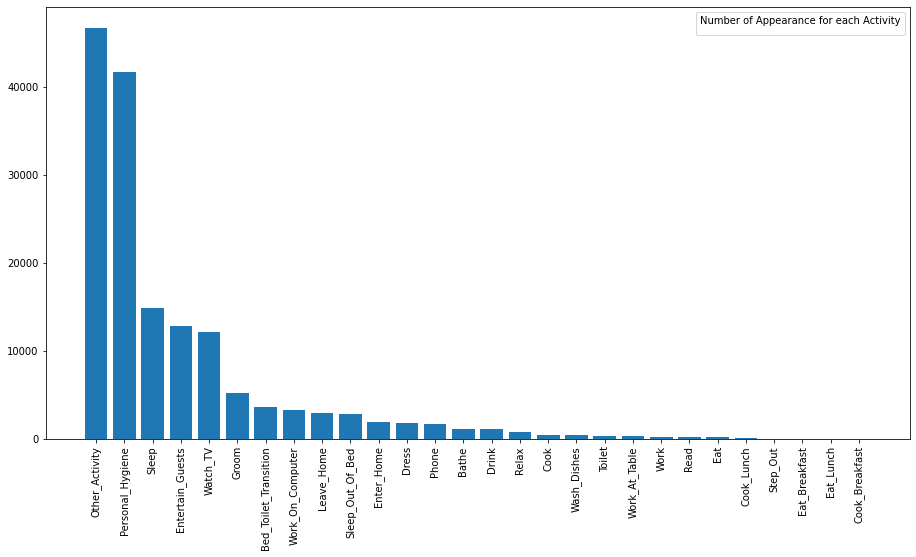

In [39]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1.5])
ax.bar(pd.unique(y_df),y_df.value_counts())
plt.xticks(rotation=90)
# plt.xticks(np.random[0,100,3])
# plt.ylim(0, 50000, 200)
plt.legend(title='Number of Appearance for each Activity')
plt.show()

In [ ]:
y_df.value_counts()

#### Data transform and spliting

In [38]:
# encoder = LabelEncoder()
# encoder.fit(y_df)
# encoded_Y = encoder.transform(y_df)

encoded_Y, encoder = TextLabelEncoderDummy.labelencoder(y_df)

In [39]:
# convert encoder variable to dummy variable
# uniques, ids = np.unique(encoded_Y, return_inverse=True)
# dummy_y = np_utils.to_categorical(ids, len(uniques))
# # dummy_y = np_utils.to_categorical(encoded_Y)

dummy_y, uniques = TextLabelEncoderDummy.encoded_to_dummy(encoded_Y)

In [40]:
dummy_y.shape, encoded_Y.shape

((157372, 28), (157372,))

In [41]:
X_train, X_test, y_train, y_test = train_test_split(unique_numeric_features, dummy_y,test_size=0.3,random_state=42)

In [42]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,test_size=0.5,random_state=42)

In [43]:
sc = StandardScaler()
S_train = sc.fit_transform(X_train)
S_val = sc.transform(X_val)
S_test = sc.transform(X_test)

In [44]:
X_train.shape,S_train.shape,y_train.shape

((110160, 21), (110160, 21), (110160, 28))

In [45]:
# pipe1a = Pipeline([
#     ('map', mapper),
# ])

In [46]:
y_train.shape, y_test.shape

((110160, 28), (23606, 28))

#### Training Model

In [47]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(60, input_dim=21, activation='relu'))
    model.add(Dense(40, activation='relu'))
    # model.add(Dense(30, activation='relu'))
    # model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(28, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [48]:

estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=100, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, S_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# print("Model accuracy: %.2f"% (accuracy*100))

Baseline: 71.04% (0.64%)


The restored model is compiled with the same arguments as the original model. Try running evaluate and predict with the loaded model:


####Retrain with modek.fit() and save model

In [49]:
model = baseline_model()
history = model.fit(S_train, y_train, batch_size=100, epochs=10, verbose=0, validation_split=0.33)
# create directory to save model
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb#scrollTo=Yh5Mu0yOgE5J
model.save('saved_model/my_model')
model.save('my_model.h5')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [50]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


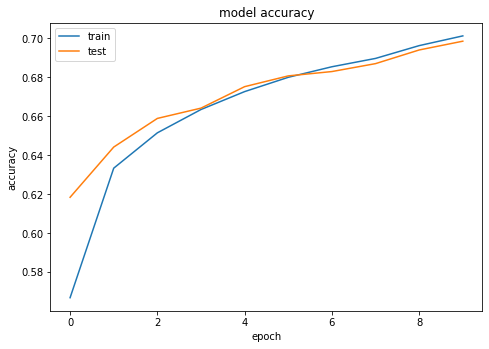

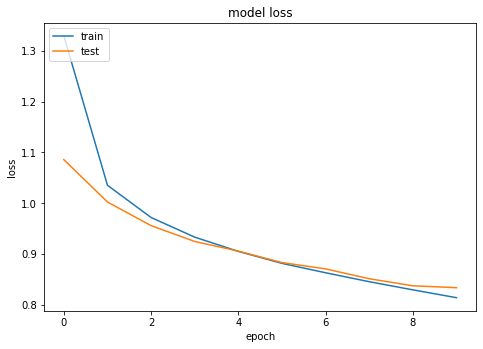

In [51]:
# fig = plt.figure()
# ax = fig.add_axes([0,0,2,2])
# ax.bar(pd.unique(y_df),y_df.value_counts())
# plt.xticks(rotation=90)
# plt.show()
# summarize history for accuracy
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

######Saved to google drive

In [52]:
# model.save("/content/drive/My Drive/Colab Notebooks/saved_model/smart_home_model")
# model.save('/content/drive/My Drive/Colab Notebooks/saved_model/smart_home_model/smart_home_model.h5')

In [53]:
# my_model directory
!ls saved_model
# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
assets	keras_metadata.pb  saved_model.pb  variables


####Load model, evaluate and predict

In [54]:
# saved_model = load_model('saved_model/my_model')
saved_model = load_model('my_model.h5')
# Check its architecture
saved_model.summary()
# 4. evaluate network
score  = saved_model.evaluate(S_val, y_val, verbose=0)
print('Restored model,Loss: {:5.2f}%,  accuracy: {:5.2f}%'.format(100 * score[0], 100 * score[1]))
# 5. make predictions
predictions = saved_model.predict(S_test, verbose=0)
print(predictions)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 60)                1320      
_________________________________________________________________
dense_31 (Dense)             (None, 40)                2440      
_________________________________________________________________
dense_32 (Dense)             (None, 28)                1148      
Total params: 4,908
Trainable params: 4,908
Non-trainable params: 0
_________________________________________________________________
Restored model,Loss: 84.36%,  accuracy: 69.72%
[[6.1542396e-06 5.7464689e-11 9.0454478e-06 ... 1.0689932e-05
  6.8741924e-06 6.0102152e-06]
 [9.2420592e-08 3.7592249e-09 5.8855621e-06 ... 1.6421393e-02
  2.2960133e-04 1.0553672e-02]
 [2.8173017e-10 1.1139657e-11 1.7384249e-11 ... 4.1529469e-10
  8.2424395e-10 7.3983610e-06]
 ...
 [8.0898346e-05 3.0245678e-07 6.8983685e-10 ... 8.

#### Reverse Predictions variables to categorical variables

In [55]:
# Reverse dummy variable to encoder variable
# reverse_dummy_predicted = uniques[predictions.argmax(1)]
# print(pd.unique(reverse_dummy_predicted).shape)

reverse_dummy_predicted =TextLabelEncoderDummy.reverse_dummy_to_encoded(predictions)
print(pd.unique(reverse_dummy_predicted).shape)

# reverse encoded Y to categorical variables
# reverse_encoded_y_predicted = encoder.inverse_transform(reverse_dummy_predicted)
# reverse_encoded_y_predicted

reverse_encoded_y_predicted = TextLabelEncoderDummy.reverse_encoded_to_text(reverse_dummy_predicted)
reverse_encoded_y_predicted

(23,)


array(['Entertain_Guests', 'Watch_TV', 'Enter_Home', ...,
       'Entertain_Guests', 'Watch_TV', 'Other_Activity'], dtype=object)

In [56]:
# reverse_test_dummy = uniques[y_test.argmax(1)]
# print(pd.unique(reverse_test_dummy).shape)

reverse_test_dummy =TextLabelEncoderDummy.reverse_dummy_to_encoded(y_test)
print(pd.unique(reverse_test_dummy).shape)

# reverse_encoded_y_test = encoder.inverse_transform(reverse_test_dummy)
# reverse_encoded_y_test

reverse_encoded_y_test = TextLabelEncoderDummy.reverse_encoded_to_text(reverse_test_dummy)
reverse_encoded_y_test

(28,)


array(['Entertain_Guests', 'Other_Activity', 'Enter_Home', ...,
       'Entertain_Guests', 'Sleep_Out_Of_Bed', 'Other_Activity'],
      dtype=object)

In [57]:
pd.unique(reverse_encoded_y_predicted).shape, pd.unique(reverse_encoded_y_test).shape

((23,), (28,))

In [58]:
pd.unique(reverse_encoded_y_predicted), pd.unique(reverse_encoded_y_test)

(array(['Entertain_Guests', 'Watch_TV', 'Enter_Home', 'Other_Activity',
        'Personal_Hygiene', 'Toilet', 'Dress', 'Sleep_Out_Of_Bed', 'Sleep',
        'Read', 'Bed_Toilet_Transition', 'Phone', 'Groom', 'Leave_Home',
        'Work_On_Computer', 'Eat', 'Bathe', 'Work_At_Table', 'Cook_Lunch',
        'Eat_Breakfast', 'Relax', 'Drink', 'Cook'], dtype=object),
 array(['Entertain_Guests', 'Other_Activity', 'Enter_Home', 'Groom',
        'Sleep', 'Phone', 'Watch_TV', 'Toilet', 'Sleep_Out_Of_Bed', 'Read',
        'Dress', 'Personal_Hygiene', 'Leave_Home', 'Work',
        'Work_On_Computer', 'Bed_Toilet_Transition', 'Drink',
        'Wash_Dishes', 'Bathe', 'Relax', 'Work_At_Table', 'Eat',
        'Eat_Lunch', 'Cook', 'Cook_Lunch', 'Eat_Breakfast', 'Step_Out',
        'Cook_Breakfast'], dtype=object))

In [59]:
# df_pred = pd.DataFrame(pd.unique(reverse_encoded_y_predicted), columns=['predicted'])
# df_pred
# df_test = pd.DataFrame(pd.unique(reverse_encoded_y_test), columns=['predicted'])
# # df_test
# # df_pred_test = pd.concat(df_pred,)

In [60]:
# new = df_test.merge(df_pred,on=['predicted'],how='outer')
# new

In [61]:
# from sklearn.linear_model import LinearRegression
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
# from sklearn.multioutput import MultiOutputRegressor,RegressorChain
# from sklearn.svm import LinearSVR
# from sklearn.tree import DecisionTreeRegressor

# def run_regression(X_train, y_train,X_test,y_test):
#     ESTIMATORS = {
#         "K-nn": KNeighborsRegressor(),                          # Accept default parameters
#         "Linear regression": LinearRegression(),
#         "RandomForestRegressor": RandomForestRegressor(),
#         "Decision Tree Regressor":DecisionTreeRegressor(),
#         "RegressorChain Regressor":RegressorChain(DecisionTreeRegressor()),
#         "MultiOutputRegressor Regressor":MultiOutputRegressor(LinearRegression()),
#         "RegressorChain_Linear Regressor":RegressorChain(LinearRegression()),
#         "MultiOutput_DecisionTree Regressor":MultiOutputRegressor(DecisionTreeRegressor())
#     }
#     # 9.1 Create an empty dictionary to collect prediction values
#     y_test_predict = dict()
#     y_mse = dict()
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#     scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1) #cross_val_predict
#     for name, estimator in ESTIMATORS.items():     
#         estimator.fit(X_train, y_train)                    # fit() with instantiated object
#         y_test_predict[name] = estimator.predict(X_test)   # Make predictions and save it in dict under key: name
#         y_mse[name] = mean_squared_error(y_test, estimator.predict(X_test))
#         print('Predicted: %s' % y_mse[name])
#     return y_test_predict

####Result Analysis

https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/

#####Classification Report, Confusion matrix and Prediction output

                       precision    recall  f1-score   support

                Dress       0.69      0.24      0.35       428
       Other_Activity       0.63      0.76      0.69      7030
     Personal_Hygiene       0.65      0.68      0.66      1901
     Entertain_Guests       0.77      0.78      0.77      6259
             Watch_TV       0.69      0.79      0.74      2255
               Toilet       0.55      0.45      0.50       798
                Sleep       0.92      0.94      0.93      1838
           Enter_Home       0.87      0.69      0.77       278
                Groom       0.79      0.38      0.51       520
     Work_On_Computer       0.57      0.37      0.44       471
     Sleep_Out_Of_Bed       0.83      0.36      0.51       148
                Phone       0.52      0.11      0.18       454
Bed_Toilet_Transition       0.91      0.87      0.89       284
           Leave_Home       0.57      0.19      0.28       311
           Cook_Lunch       0.83      0.71      0.77  

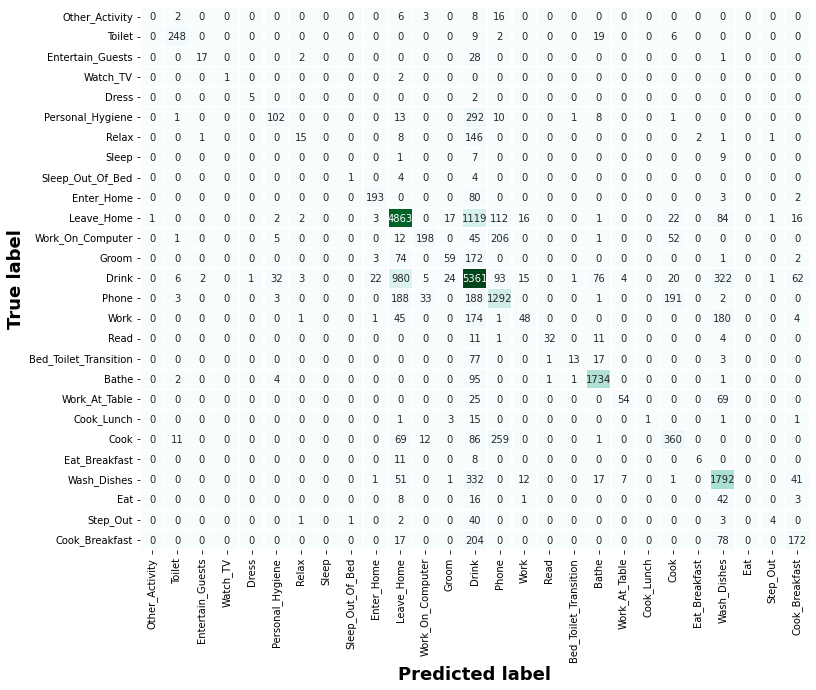

Streaming output truncated to the last 5000 lines.
Test: Dress -------- Predicted: (Dress)
Test: Personal_Hygiene -------- Predicted: (Other_Activity)
Test: Personal_Hygiene -------- Predicted: (Personal_Hygiene)
Test: Other_Activity -------- Predicted: (Other_Activity)
Test: Relax -------- Predicted: (Relax)
Test: Entertain_Guests -------- Predicted: (Other_Activity)
Test: Other_Activity -------- Predicted: (Other_Activity)
Test: Dress -------- Predicted: (Dress)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Entertain_Guests -------- Predicted: (Other_Activity)
Test: Groom -------- Predicted: (Personal_Hygiene)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Watch_TV -------- Predicted: (Watch_TV)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Personal_Hygiene -------- Predicted: (Other_Activity)
Test: Dress -------- Predicted: (Other_Activity)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Entertain_G

In [96]:
# matrix = classification_report(actual,predicted,labels=[1,0])
ResultSummary.classification_reportx(reverse_encoded_y_test,reverse_encoded_y_predicted)
ResultSummary.confusion_matrixx(reverse_encoded_y_test, reverse_encoded_y_predicted,12,10)
ResultSummary.actual_n_predictions(reverse_encoded_y_test,reverse_encoded_y_predicted)

In [63]:
tested_df = pd.DataFrame(reverse_encoded_y_test, columns=['test'])
pred_df = pd.DataFrame(reverse_encoded_y_predicted, columns=['pred'])

# np.unique(reverse_test_dummy)?

uniq, counts = np.unique(reverse_test_dummy, return_counts=True)

print(np.asarray((uniq, counts))[0])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


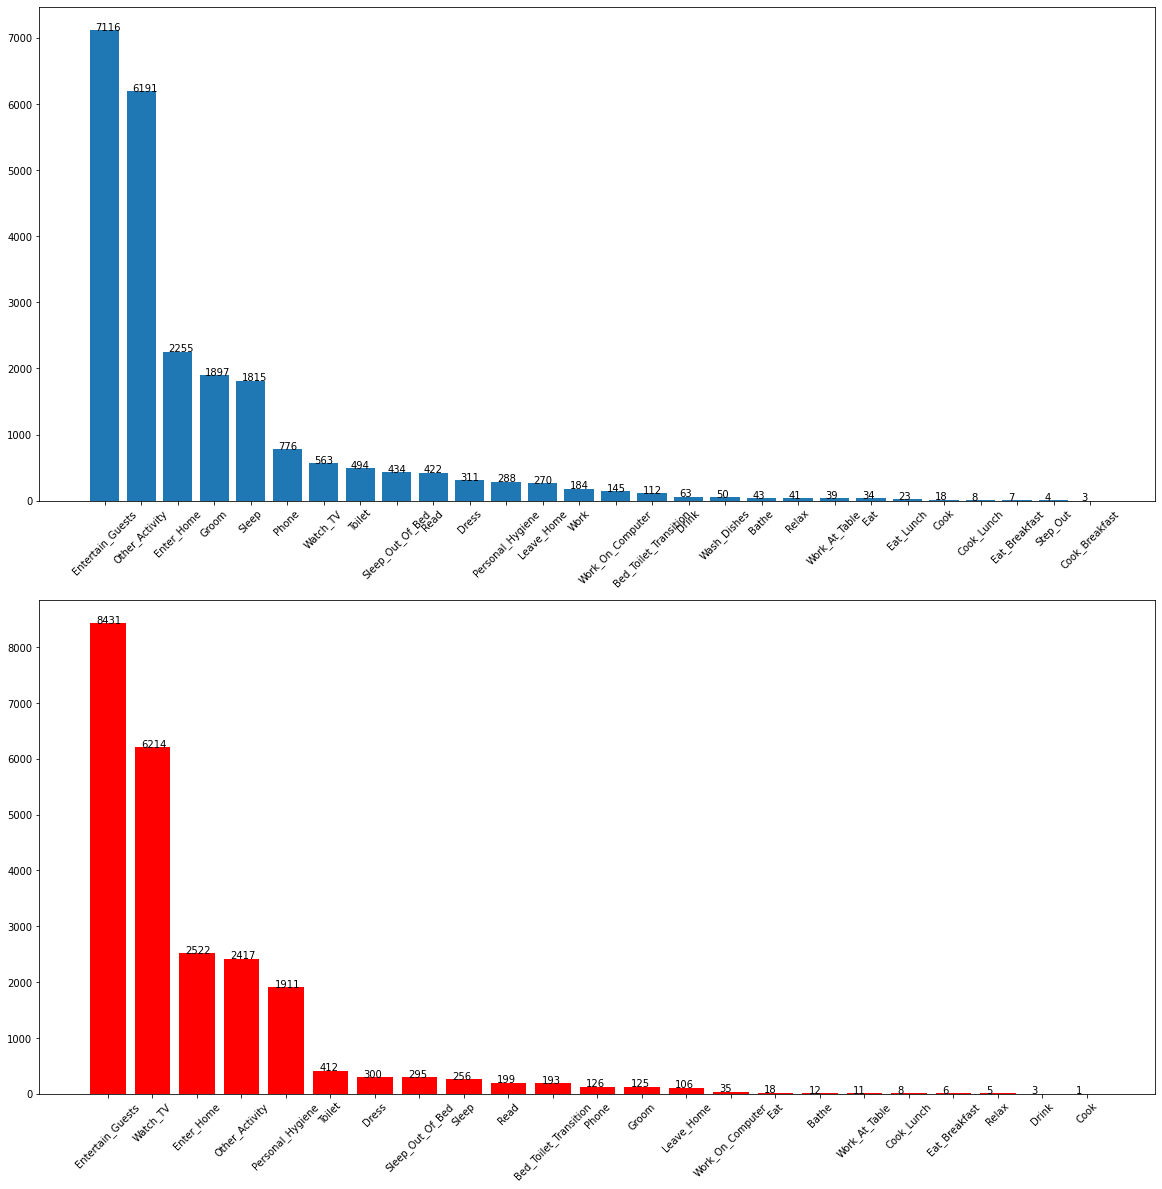

In [76]:
# reverse_test_dummy 
# reverse_dummy_predicted

fig = plt.figure(figsize=(20, 20))
plt.subplot(211)
ax = plt.bar(pd.unique(tested_df['test']),tested_df['test'].value_counts())
plt.xticks(rotation=45)
xlocs, xlabs = plt.xticks()
for i, v in enumerate(tested_df['test'].value_counts()):
    plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
plt.subplot(212) # creates 2nd subplot with yellow background
plt.bar(pd.unique(pred_df['pred']),pred_df['pred'].value_counts(), color = 'r')
plt.xticks(rotation=45)
xlocs, xlabs = plt.xticks()
for i, v in enumerate(pred_df['pred'].value_counts()):
    plt.text(xlocs[i] - 0.25, v + 0.01, str(v))


In [97]:
for c in ax:
  print(c)

Rectangle(xy=(-0.4, 0), width=0.8, height=7143, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=6307, angle=0)
Rectangle(xy=(1.6, 0), width=0.8, height=2211, angle=0)
Rectangle(xy=(2.6, 0), width=0.8, height=1860, angle=0)
Rectangle(xy=(3.6, 0), width=0.8, height=1728, angle=0)
Rectangle(xy=(4.6, 0), width=0.8, height=827, angle=0)
Rectangle(xy=(5.6, 0), width=0.8, height=517, angle=0)
Rectangle(xy=(6.6, 0), width=0.8, height=489, angle=0)
Rectangle(xy=(7.6, 0), width=0.8, height=430, angle=0)
Rectangle(xy=(8.6, 0), width=0.8, height=426, angle=0)
Rectangle(xy=(9.6, 0), width=0.8, height=300, angle=0)
Rectangle(xy=(10.6, 0), width=0.8, height=298, angle=0)
Rectangle(xy=(11.6, 0), width=0.8, height=276, angle=0)
Rectangle(xy=(12.6, 0), width=0.8, height=159, angle=0)
Rectangle(xy=(13.6, 0), width=0.8, height=152, angle=0)
Rectangle(xy=(14.6, 0), width=0.8, height=124, angle=0)
Rectangle(xy=(15.6, 0), width=0.8, height=72, angle=0)
Rectangle(xy=(16.6, 0), width=0.8, height=57, angle=0)

In [105]:
tested_df.head(2)

,test
0,Other_Activity
1,Other_Activity


In [98]:
from sklearn.metrics import precision_score
precision = precision_score(reverse_encoded_y_test, reverse_encoded_y_predicted, average='micro')
print('Precision: %.3f' % precision)

Precision: 0.702


In [99]:
pd.unique(reverse_encoded_y_test)

array(['Other_Activity', 'Toilet', 'Entertain_Guests', 'Watch_TV',
       'Dress', 'Personal_Hygiene', 'Relax', 'Sleep', 'Sleep_Out_Of_Bed',
       'Enter_Home', 'Leave_Home', 'Work_On_Computer', 'Groom', 'Drink',
       'Phone', 'Work', 'Read', 'Bed_Toilet_Transition', 'Bathe',
       'Work_At_Table', 'Cook_Lunch', 'Cook', 'Eat_Breakfast',
       'Wash_Dishes', 'Eat', 'Step_Out', 'Cook_Breakfast'], dtype=object)

#####Confusion matrix

In [100]:
# pd.crosstab(reverse_encoded_y_test, reverse_encoded_y_predicted, rownames=['True'], colnames=['Predicted'], margins=True)

In [ ]:
confusion_matrixx(reverse_encoded_y_test, reverse_encoded_y_predicted,12,10)

####Actual and predicted comparison

In [95]:
for i in range(len(reverse_encoded_y_test)):
    print("Test: %s -------- Predicted: (%s)" % (reverse_encoded_y_test[i], reverse_encoded_y_predicted[i]))

# pred = list()
# for i in range(4):
#     pred.append(uniques[predictions.argmax(1)])

Streaming output truncated to the last 5000 lines.
Test: Dress -------- Predicted: (Dress)
Test: Personal_Hygiene -------- Predicted: (Other_Activity)
Test: Personal_Hygiene -------- Predicted: (Personal_Hygiene)
Test: Other_Activity -------- Predicted: (Other_Activity)
Test: Relax -------- Predicted: (Relax)
Test: Entertain_Guests -------- Predicted: (Other_Activity)
Test: Other_Activity -------- Predicted: (Other_Activity)
Test: Dress -------- Predicted: (Dress)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Entertain_Guests -------- Predicted: (Other_Activity)
Test: Groom -------- Predicted: (Personal_Hygiene)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Watch_TV -------- Predicted: (Watch_TV)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Personal_Hygiene -------- Predicted: (Other_Activity)
Test: Dress -------- Predicted: (Other_Activity)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Entertain_G

###Playground

####Basic before predicting

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from keras.models import load_model
# from keras.layers import Dense
# from keras.layers import LSTM
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

# multi-class classification with Keras
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import(
    classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error
)
from sklearn.preprocessing import (
    StandardScaler, LabelBinarizer, FunctionTransformer,PolynomialFeatures, OrdinalEncoder,LabelEncoder,MinMaxScaler
)
# from sklearn_pandas import DataFrameMapper, CategoricalImputer
# from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.feature_selection import VarianceThreshold
from keras.utils import np_utils

In [ ]:
class ResultSummary:
  # matrix = classification_report(actual,predicted,labels=[1,0])
  def classification_reportx(y_test,y_predicted):
    matrix = classification_report(y_test,y_predicted, labels=pd.unique(y_predicted))
    # matrix = classification_report(reverse_encoded_y_test,reverse_encoded_y_predicted, labels=pd.unique(reverse_encoded_y_predicted))
    print(matrix)
  # classification_reportx(reverse_encoded_y_test,reverse_encoded_y_predicted)


  # confusion_matrix(reverse_encoded_y_test, reverse_encoded_y_predicted)
  # pd.crosstab(reverse_encoded_y_test, reverse_encoded_y_predicted, rownames=['True'], colnames=['Predicted'], margins=True)
  def confusion_matrixx(y_test, y_pred,figsize1,figsize2):
    %matplotlib inline
    # fig, ax = plt.subplots(figsize=(12,10))
    fig, ax = plt.subplots(figsize=(figsize1,figsize2))
    # cm = confusion_matrix(reverse_encoded_y_test, reverse_encoded_y_predicted)
    cm = confusion_matrix(y_test, y_pred)
    # df_cm = pd.DataFrame(cm, index=pd.unique(reverse_encoded_y_test), columns=pd.unique(reverse_encoded_y_test))
    df_cm = pd.DataFrame(cm, index=pd.unique(y_test), columns=pd.unique(y_test))
    ax = sns.heatmap(df_cm,  cbar = False, cmap="BuGn", annot=True, fmt="d", linewidths=.5, ax=ax)
    # plt.setp(ax.get_xticklabels(), rotation=45)
    plt.ylabel('True label', fontweight='bold', fontsize = 18)
    plt.xlabel('Predicted label', fontweight='bold', fontsize = 18) 
    plt.show()
  # confusion_matrixx(reverse_encoded_y_test, reverse_encoded_y_predicted,12,10)
  


  def actual_n_predictions(reverse_encoded_y_test,reverse_encoded_y_predicted):
    for i in range(len(reverse_encoded_y_test)):
      print("Test: %s -------- Predicted: (%s)" % (reverse_encoded_y_test[i], reverse_encoded_y_predicted[i]))



# class for Y convertions
class TextLabelEncoderDummy:

  def labelencoder(y_df):
    encoder = LabelEncoder()
    encoder.fit(y_df)
    encoded_Y = encoder.transform(y_df)
    return encoded_Y, encoder


  def encoded_to_dummy(encoded_Y):
    # convert encoder variable to dummy variable
    uniques, ids = np.unique(encoded_Y, return_inverse=True)
    dummy_y = np_utils.to_categorical(ids, len(uniques))
    # dummy_y = np_utils.to_categorical(encoded_Y)
    return dummy_y, uniques


  def reverse_dummy_to_encoded(y_test):
    reverse_dummy = uniques[y_test.argmax(1)]
    return reverse_dummy


  def reverse_encoded_to_text(reverse_dummy):
    reverse_encoded = encoder.inverse_transform(reverse_dummy)
    return reverse_encoded

####Predicting process

In [ ]:
# general
# !gdown --id 1-Basb-wsvjRk0xzFGzi3KCk3Bb133eYu # download smart_home_model
# !gdown --id 1-OkhVbPbEsf82JjHw8Nylf9l5SE3Kxz4 # download smart_home_s_val
# !gdown --id 1-JghvYFOyFIkD4XhDEbSHTQBDkwUlnL-  # download smart_home_y_val

# specific
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# test id 1wRHlvI2IvKIJuJ6Bt2SUeJqiv5eCOWJ3
file_id = '1-JghvYFOyFIkD4XhDEbSHTQBDkwUlnL-'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

file_id = '1-OkhVbPbEsf82JjHw8Nylf9l5SE3Kxz4'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

file_id = '1-Basb-wsvjRk0xzFGzi3KCk3Bb133eYu'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])


In [ ]:
# load model with evaluation dataset
saved_model = load_model("/content/drive/My Drive/Colab Notebooks/saved_model/my_model")
ss_val = np.loadtxt('smart_home_s_val.csv') 
yy_val = np.loadtxt('smart_home_y_val.csv')

In [ ]:
# smart_home_model_link = https://drive.google.com/file/d/1-Basb-wsvjRk0xzFGzi3KCk3Bb133eYu/view?usp=sharing
# smart_home_s_val_link = https://drive.google.com/file/d/1-OkhVbPbEsf82JjHw8Nylf9l5SE3Kxz4/view?usp=sharing
# smart_home_s_val_link = https://drive.google.com/file/d/1-JghvYFOyFIkD4XhDEbSHTQBDkwUlnL-/view?usp=sharing
smart_home_test_data_link = https://drive.google.com/file/d/1-OmlmoCjvQdInhmfqlxjiJ4efhRMyRCf/view?usp=sharing

data_pred = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,0,0,0] # copy and paste your data here


In [ ]:
# Let's create prediction and result display function
data_pred_df = pd.DataFrame(data_pred, columns=['lastSensorEventHours', 'lastSensorEventSeconds', 'lastSensorDayOfWeek',
       'windowDuration', 'timeSinceLastSensorEvent', 'prevDominantSensor1',
       'prevDominantSensor2', 'lastSensorID', 'lastSensorLocation',
       'lastMotionLocation', 'complexity', 'activityChange', 'areaTransitions',
       'numDistinctSensors', 'sensorCount-Bathroom', 'sensorCount-Bedroom',
       'sensorCount-Chair', 'sensorCount-DiningRoom', 'sensorCount-Hall',
       'sensorCount-Ignore', 'sensorCount-Kitchen', 'sensorCount-LivingRoom',
       'sensorCount-Office', 'sensorCount-OutsideDoor', 'sensorCount-WorkArea',
       'sensorElTime-Bathroom', 'sensorElTime-Bedroom', 'sensorElTime-Chair',
       'sensorElTime-DiningRoom', 'sensorElTime-Hall', 'sensorElTime-Ignore',
       'sensorElTime-Kitchen', 'sensorElTime-LivingRoom',
       'sensorElTime-Office', 'sensorElTime-OutsideDoor',
       'sensorElTime-WorkArea'], dtype='float64')

X_pred_df = data_pred_df.drop(labels=['numDistinctSensors','sensorCount-Chair','sensorCount-DiningRoom',
 'sensorCount-Hall','sensorCount-Office','sensorCount-WorkArea','sensorElTime-Chair','sensorElTime-DiningRoom',
 'sensorElTime-Hall','sensorElTime-Office',
 'sensorElTime-WorkArea','lastSensorLocation','lastMotionLocation', 'sensorElTime-OutsideDoor', 'lastSensorEventSeconds'], axis=1)
# data_shuffled = data.sample(frac=1)
# X_pred_df = data_dropped.drop(labels=['activity'], axis=1)
# y_pred_df = data_dropped['activity']
# Scaling data
sc = StandardScaler()
# S_train = sc.fit_transform(X_train)
S_test_pred = sc.fit_transform(X_pred_df)


In [ ]:
y_pred_df = ['Sleep', 'Other_Activity', 'Entertain_Guests', 'Watch_TV',
       'Bed_Toilet_Transition', 'Toilet', 'Groom', 'Personal_Hygiene',
       'Eat', 'Dress', 'Work_On_Computer', 'Leave_Home', 'Cook', 'Relax',
       'Enter_Home', 'Drink', 'Phone', 'Sleep_Out_Of_Bed',
       'Work_At_Table', 'Read', 'Cook_Lunch', 'Bathe', 'Wash_Dishes',
       'Step_Out', 'Work', 'Eat_Breakfast', 'Cook_Breakfast', 'Eat_Lunch']

# encode and dummy transform
# encoded_Y_pred, encoder = TextLabelEncoderDummy.labelencoder(y_pred_df)
encoded_Y_pred, encoder = TextLabelEncoderDummy.labelencoder(y_pred_df)
dummy_y_pred, uniques = TextLabelEncoderDummy.encoded_to_dummy(encoded_Y_pred)



In [ ]:

saved_model.summary()
score  = saved_model.evaluate(S_val, y_val, verbose=0)
print('Restored model,Loss: {:5.2f}%,  accuracy: {:5.2f}%'.format(100 * score[0], 100 * score[1]))

# 5. make predictions
preds = saved_model.predict(S_test, verbose=0)
print(pred)


In [ ]:
# Reverse predictios
reverse_dummy_pred =TextLabelEncoderDummy.reverse_dummy_to_encoded(pred)
print(pd.unique(reverse_dummy_pred).shape)

reverse_encoded_y_pred = TextLabelEncoderDummy.reverse_encoded_to_text(reverse_dummy_pred)
reverse_encoded_y_pred

# Show output
# ResultSummary.classification_reportx(y_pred_df,reverse_encoded_y_pred)
# ResultSummary.confusion_matrixx(y_pred_df, reverse_encoded_y_pred,12,10)
# ResultSummary.actual_n_predictions(y_pred_df,reverse_encoded_y_pred)

In [ ]:
ResultSummary.actual_n_predictions(y_pred_df,reverse_encoded_y_pred)

In [ ]:
print(predictions.shape, y_test.shape)

(23606, 28) (23606, 28)


In [ ]:
for layer in model.layers:
    weights = layer.get_weights()

b# from keras.utils import plot_model
# plot_model(model, to_file='/tmp/model.png', show_shapes=True,)
weights

In [ ]:
# Now we can check the model’s performance on test data:
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [ ]:
# Saved datasets and download
# from google.colab import files
# ss_val = pd.DataFrame(S_val)
# yy_val = pd.DataFrame(y_val)
# ss_val.to_csv('/content/drive/My Drive/Colab Notebooks/saved_model/smart_home_model/smart_home_s_val.csv') 
# yy_val.to_csv('/content/drive/My Drive/Colab Notebooks/saved_model/smart_home_model/smart_home_y_val.csv') 

# !zip -r /content/saved_model_download.zip /content/saved_model
# files.download("saved_model_download.zip")

# test_data = data_shuffled.iloc[500:100000,]
# test_data.head(4)
test_data.to_csv('/content/drive/My Drive/Colab Notebooks/saved_model/smart_home_model/smart_home_test_data.csv') 

In [ ]:
y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1SooKSw8M4ACbznKjnNrYvJ5wxuqJ-YCk' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


with open(fname, 'r') as f:
  print(f.read())

In [ ]:
# qr52323694